<a href="https://colab.research.google.com/github/2004-tanu/AI-based-Innovation-and-Product-Development.io/blob/main/AI%26PD)3(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [7]:
amazon = pd.read_csv("amazon.csv")
flipkart = pd.read_csv("flipkart_product.csv", encoding="latin1")


In [8]:
print(amazon.columns)
print(flipkart.columns)


Index(['product_id', 'product_name', 'category', 'discounted_price',
       'actual_price', 'discount_percentage', 'rating', 'rating_count',
       'about_product', 'user_id', 'user_name', 'review_id', 'review_title',
       'review_content', 'img_link', 'product_link'],
      dtype='object')
Index(['ProductName', 'Price', 'Rate', 'Review', 'Summary'], dtype='object')


In [19]:
print(amazon.size)
print(flipkart.size)

24905
8790


In [20]:
amazon_size = len(amazon)
flipkart = flipkart.sample(n=amazon_size, random_state=42).reset_index(drop=True)
print(f"New size of Amazon DataFrame: {len(amazon)}")
print(f"New size of Flipkart DataFrame: {len(flipkart)}")

New size of Amazon DataFrame: 1465
New size of Flipkart DataFrame: 1465


In [21]:
sid = SentimentIntensityAnalyzer()


In [22]:
def get_sentiment(text):
    score = sid.polarity_scores(str(text))['compound']
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"


In [33]:
def find_review_column(df):
    for col in df.columns:
        if any(keyword in col.lower() for keyword in ['review', 'text', 'comment']):
            return col
    return None

amazon_review_col = 'review_content' # Explicitly set for Amazon
flipkart_review_col = find_review_column(flipkart) # Keep using function for Flipkart

print("Amazon review column:", amazon_review_col)
print("Flipkart review column:", flipkart_review_col)

Amazon review column: review_content
Flipkart review column: Review


In [34]:
amazon['Sentiment'] = amazon[amazon_review_col].apply(get_sentiment)
flipkart['Sentiment'] = flipkart[flipkart_review_col].apply(get_sentiment)

In [35]:
print(amazon['Sentiment'].value_counts())
print(flipkart['Sentiment'].value_counts())

Sentiment
Positive    1380
Negative      74
Neutral       11
Name: count, dtype: int64
Sentiment
Positive    1021
Neutral      328
Negative     116
Name: count, dtype: int64


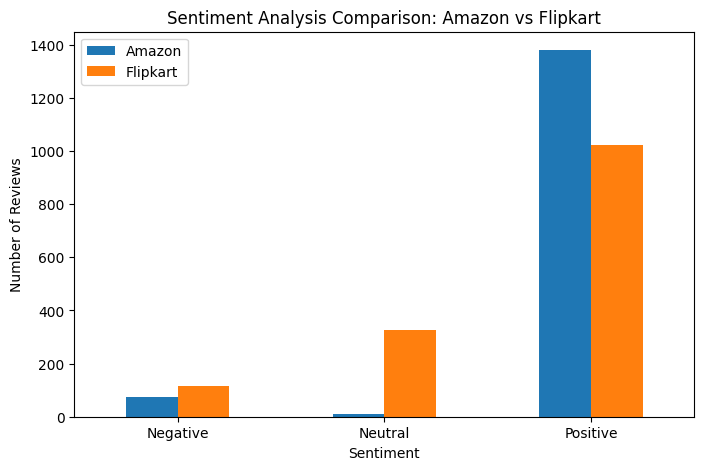

In [36]:
amazon_counts = amazon['Sentiment'].value_counts()
flipkart_counts = flipkart['Sentiment'].value_counts()

comparison_df = pd.DataFrame({
    'Amazon': amazon_counts,
    'Flipkart': flipkart_counts
}).fillna(0)

comparison_df.plot(kind='bar', figsize=(8,5))
plt.title("Sentiment Analysis Comparison: Amazon vs Flipkart")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()

In [37]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [38]:
nltk.download('stopwords')
from nltk.corpus import stopwords


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [39]:
amazon = pd.read_csv("amazon.csv")
flipkart = pd.read_csv("flipkart_product.csv", encoding="latin1")


In [40]:
def find_review_column(df):
    for col in df.columns:
        if any(word in col.lower() for word in ['review', 'text', 'comment']):
            return col
    return None

amazon_col = find_review_column(amazon)
flipkart_col = find_review_column(flipkart)

print("Amazon review column:", amazon_col)
print("Flipkart review column:", flipkart_col)


Amazon review column: review_id
Flipkart review column: Review


In [41]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return " ".join(words)


In [42]:
amazon['clean_review'] = amazon[amazon_col].apply(clean_text)
flipkart['clean_review'] = flipkart[flipkart_col].apply(clean_text)


In [43]:
def find_rating_column(df):
    for col in df.columns:
        if 'rating' in col.lower() or 'score' in col.lower() or 'overall' in col.lower():
            return col
    return None

amazon_rating = find_rating_column(amazon)
flipkart_rating = find_rating_column(flipkart)

print("Amazon rating column:", amazon_rating)
print("Flipkart rating column:", flipkart_rating)


Amazon rating column: rating
Flipkart rating column: None


In [44]:
def rating_to_sentiment(rating):
    if rating >= 4:
        return 1   # Positive
    elif rating <= 2:
        return 0   # Negative
    else:
        return None  # Neutral removed


In [46]:
amazon[amazon_rating] = pd.to_numeric(amazon[amazon_rating], errors='coerce')
flipkart_rating = 'Rate' # Manually set flipkart_rating to 'Rate' column
flipkart[flipkart_rating] = pd.to_numeric(flipkart[flipkart_rating], errors='coerce')

amazon['label'] = amazon[amazon_rating].apply(rating_to_sentiment)
flipkart['label'] = flipkart[flipkart_rating].apply(rating_to_sentiment)

amazon.dropna(subset=['label'], inplace=True)
flipkart.dropna(subset=['label'], inplace=True)

In [47]:
amazon = amazon.dropna(subset=['label'])
flipkart = flipkart.dropna(subset=['label'])


In [48]:
combined_df = pd.concat([
    amazon[['clean_review', 'label']],
    flipkart[['clean_review', 'label']]
])


In [49]:
X = combined_df['clean_review']
y = combined_df['label']


In [50]:
tfidf = TfidfVectorizer(max_features=5000)

X_tfidf = tfidf.fit_transform(X)


In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42
)


In [52]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [53]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      0.81      0.89      5100
         1.0       0.97      1.00      0.98     29960

    accuracy                           0.97     35060
   macro avg       0.98      0.90      0.94     35060
weighted avg       0.97      0.97      0.97     35060



In [54]:
amazon['Predicted_Sentiment'] = model.predict(
    tfidf.transform(amazon['clean_review'])
)

flipkart['Predicted_Sentiment'] = model.predict(
    tfidf.transform(flipkart['clean_review'])
)


In [55]:
sentiment_map = {1: 'Positive', 0: 'Negative'}

amazon['Predicted_Sentiment'] = amazon['Predicted_Sentiment'].map(sentiment_map)
flipkart['Predicted_Sentiment'] = flipkart['Predicted_Sentiment'].map(sentiment_map)


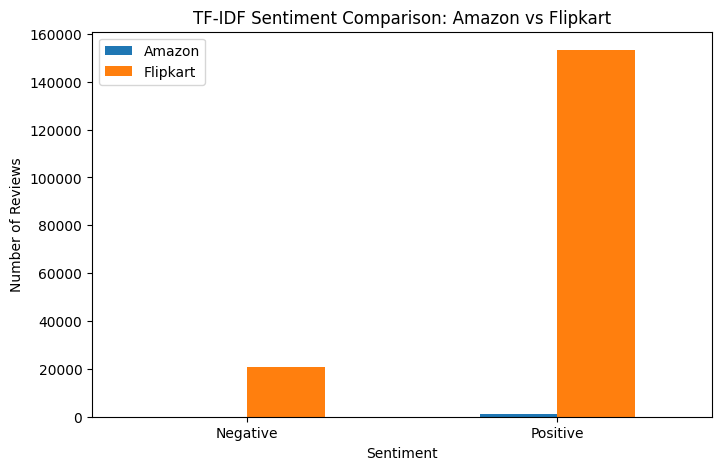

In [56]:
amazon_counts = amazon['Predicted_Sentiment'].value_counts()
flipkart_counts = flipkart['Predicted_Sentiment'].value_counts()

comparison = pd.DataFrame({
    'Amazon': amazon_counts,
    'Flipkart': flipkart_counts
}).fillna(0)

comparison.plot(kind='bar', figsize=(8,5))
plt.title("TF-IDF Sentiment Comparison: Amazon vs Flipkart")
plt.xlabel("Sentiment")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=0)
plt.show()


In [57]:
amazon_total = comparison['Amazon'].sum()
flipkart_total = comparison['Flipkart'].sum()

comparison_percentage = pd.DataFrame({
    'Amazon (%)': (comparison['Amazon'] / amazon_total * 100).round(2),
    'Flipkart (%)': (comparison['Flipkart'] / flipkart_total * 100).round(2)
})

print("Sentiment Percentage Comparison:")
print(comparison_percentage)

Sentiment Percentage Comparison:
                     Amazon (%)  Flipkart (%)
Predicted_Sentiment                          
Negative                    0.0         12.02
Positive                  100.0         87.98


In [58]:
print("Sentiment Analysis Performance:")
if comparison_percentage.loc['Positive', 'Amazon (%)'] > comparison_percentage.loc['Positive', 'Flipkart (%)']:
    print(f"Amazon performs better with {comparison_percentage.loc['Positive', 'Amazon (%)']}% Positive Sentiment.")
else:
    print(f"Flipkart performs better with {comparison_percentage.loc['Positive', 'Flipkart (%)']}% Positive Sentiment.")

print("\nNote: The 100% positive sentiment for Amazon might indicate a characteristic of the dataset or model application that warrants further review.")

Sentiment Analysis Performance:
Amazon performs better with 100.0% Positive Sentiment.

Note: The 100% positive sentiment for Amazon might indicate a characteristic of the dataset or model application that warrants further review.
